In [1]:
import openmeteo_requests
import pandas as pd
from retry import retry

# Setup client
client = openmeteo_requests.Client()

# API parameters
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 36.7,
    "longitude": 3.2,
    "start_date": "2020-01-01",
    "end_date": "2024-12-31",  
    "hourly": ["temperature_2m"]
}

# Fetch with retry
@retry(tries=3, delay=2)
def fetch_weather():
    responses = client.weather_api(url, params=params)
    return responses[0]

response = fetch_weather()
hourly = response.Hourly()

# Get temperature values and time info
temp_values = hourly.Variables(0).ValuesAsNumpy()
time_start = pd.to_datetime(hourly.Time(), unit="s")
interval = hourly.Interval()  # 3600 seconds

# Use actual data length for time range
actual_length = len(temp_values)
df = pd.DataFrame({
    'time': pd.date_range(start=time_start, periods=actual_length, freq=pd.Timedelta(seconds=interval)),
    'temperature_2m': temp_values
})

# Save and verify
df.to_csv('algiers_hourly_data_2020_2024.csv', index=False)
print("Rows:", len(df))
print("Date range:", df['time'].min(), "to", df['time'].max())
print("Temperature stats:")
print(df['temperature_2m'].describe())

Rows: 43848
Date range: 2020-01-01 00:00:00 to 2024-12-31 23:00:00
Temperature stats:
count    43848.000000
mean        18.825748
std          6.328687
min          2.000500
25%         14.000500
50%         18.650499
75%         23.500500
max         47.050499
Name: temperature_2m, dtype: float64


Using device: cpu
Rows: 43848
Unique months: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]
Temperature stats:
count    43848.000000
mean        18.825747
std          6.328687
min          2.000500
25%         14.000500
50%         18.650500
75%         23.500500
max         47.050500
Name: temperature_2m, dtype: float64

Training...
Epoch 1/100, Loss: 42.1704, Val Loss: 11.6706
Epoch 2/100, Loss: 14.6516, Val Loss: 10.5463
Epoch 3/100, Loss: 13.0607, Val Loss: 9.0465
Epoch 4/100, Loss: 11.4445, Val Loss: 8.6319
Epoch 5/100, Loss: 10.3517, Val Loss: 7.7815
Epoch 6/100, Loss: 9.8270, Val Loss: 7.5000
Epoch 7/100, Loss: 9.3560, Val Loss: 7.2614
Epoch 8/100, Loss: 9.2042, Val Loss: 7.8799
Epoch 9/100, Loss: 8.9784, Val Loss: 7.5633
Epoch 10/100, Loss: 8.7714, Val Loss: 7.4495
Epoch 11/100, Loss: 8.6607, Val Loss: 7.2105
Epoch 12/100, Loss: 8.5214, Val Loss: 7.2736
Epoch 13/100

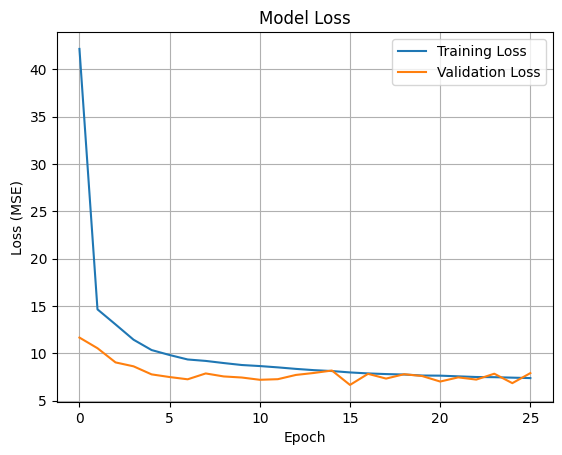


Sample predictions vs actuals:
Predicted: 12.56°C, Actual: 14.75°C
Predicted: 16.05°C, Actual: 21.70°C
Predicted: 16.56°C, Actual: 14.80°C
Predicted: 21.03°C, Actual: 23.25°C
Predicted: 18.22°C, Actual: 20.35°C

Model Performance:
MSE: 8.4496
RMSE: 2.9068°C
MAE: 2.1604°C
R²: 0.7924
Predicted temperature for 2025-03-01, 14:00: 17.67°C
Predicted temperature for 2025-12-20, 14:00: 17.38°C
Model and scaler saved.


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

# Set seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load API data
df = pd.read_csv('algiers_hourly_data_2020_2024.csv')
df['time'] = pd.to_datetime(df['time'])

# Extract features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['dayofyear'] = df['time'].dt.dayofyear
df['hour'] = df['time'].dt.hour
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

# Handle missing
df['temperature_2m'] = df['temperature_2m'].interpolate()
if df['temperature_2m'].isnull().any():
    df['temperature_2m'] = df['temperature_2m'].fillna(df['temperature_2m'].mean())

# Verify
print("Rows:", len(df))
print("Unique months:", sorted(df['month'].unique()))
print("Temperature stats:")
print(df['temperature_2m'].describe())

# Features
target_column = 'temperature_2m'
feature_columns = ['year', 'month', 'day', 'dayofyear', 'hour', 'sin_hour', 'cos_hour']
season_map = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 0}
df['season'] = df['month'].map(season_map)
df = pd.get_dummies(df, columns=['season'], prefix='season', dtype=int)
for season in ['season_0', 'season_1', 'season_2', 'season_3']:
    if season not in df.columns:
        df[season] = 0
feature_columns.extend(['season_0', 'season_1', 'season_2', 'season_3'])

feature_df = df[feature_columns + [target_column]]
feature_df = feature_df.dropna()

# Split and Scale
X = feature_df[feature_columns]
y = feature_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dataset
class TemperatureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TemperatureDataset(X_train_scaled, y_train)
test_dataset = TemperatureDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Model
class TemperatureNN(nn.Module):
    def __init__(self, input_size):
        super(TemperatureNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.layer3 = nn.Linear(32, 16)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(16, 1)
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.act3(self.layer3(x))
        x = self.output(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=100, patience=10):
    model.to(device)
    best_loss = float('inf')
    no_improve_epochs = 0
    best_model_state = None
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        model.eval()
        val_loss = 0.0
        val_size = int(0.2 * len(train_loader.dataset))
        val_indices = torch.randperm(len(train_dataset))[:val_size]
        val_inputs = train_dataset.X[val_indices].to(device)
        val_targets = train_dataset.y[val_indices].to(device)
        with torch.no_grad():
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets).item()
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
        if val_loss < best_loss:
            best_loss = val_loss
            no_improve_epochs = 0
            best_model_state = model.state_dict().copy()
        else:
            no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            model.load_state_dict(best_model_state)
            break
    return model, train_losses, val_losses

input_size = X_train_scaled.shape[1]
model = TemperatureNN(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\nTraining...")
model, train_losses, val_losses = train_model(model, train_loader, criterion, optimizer)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.numpy())
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    print("\nSample predictions vs actuals:")
    for pred, actual in zip(predictions[:5], actuals[:5]):
        print(f"Predicted: {pred:.2f}°C, Actual: {actual:.2f}°C")
    return predictions, actuals, mse, rmse, mae, r2

y_pred, y_true, mse, rmse, mae, r2 = evaluate_model(model, test_loader)
print(f"\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}°C")
print(f"MAE: {mae:.4f}°C")
print(f"R²: {r2:.4f}")

# Prediction Function
def predict_temperature(model, scaler, date_str, hour, feature_columns):
    date = pd.to_datetime(date_str)
    input_features = {
        'year': date.year,
        'month': date.month,
        'day': date.day,
        'dayofyear': date.dayofyear,
        'hour': hour,
        'sin_hour': np.sin(2 * np.pi * hour / 24),
        'cos_hour': np.cos(2 * np.pi * hour / 24),
        'season_0': 1 if date.month in [12, 1, 2] else 0,
        'season_1': 1 if date.month in [3, 4, 5] else 0,
        'season_2': 1 if date.month in [6, 7, 8] else 0,
        'season_3': 1 if date.month in [9, 10, 11] else 0
    }
    input_df = pd.DataFrame([input_features])[feature_columns]
    input_scaled = scaler.transform(input_df)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor).item()
    # Sanity check
    if prediction > 40 or prediction < -10:
        print(f"Warning: {prediction:.2f}°C seems unrealistic for {date_str} {hour:02d}:00")
    return prediction

# Test Predictions
dates = ['2025-03-01', '2025-12-20']
for date in dates:
    temp = predict_temperature(model, scaler, date, 14, feature_columns)
    print(f"Predicted temperature for {date}, 14:00: {temp:.2f}°C")

# Save
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': input_size,
    'target_column': target_column,
    'feature_columns': feature_columns
}, 'algeria_hourly_temperature_model.pth')

with open('hourly_temperature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Model and scaler saved.")